In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from Bio.PDB import PDBParser, PPBuilder
import py3Dmol, pathlib
import pcmap
import math
from tqdm import trange

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch #https://github.com/facebookresearch/esm
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 3 on the node
print(torch.cuda.get_device_name(0))

Tesla V100-SXM2-32GB


In [2]:
def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


### Loading PPint_DB

In [3]:
### Loading df
PPint_interactions = pd.read_csv("/work3/s232958/data/PPint_DB/disordered_interfaces_no_cutoff_filtered_nonredundant80_3å_5.csv.gz",index_col=0).reset_index(drop=True)

### Creating dictionary : PDB_interface_name : {"seq_target" : target sequence, "seq_binder" : binder sequence,}
PPint_interactions_dict = {}

for idx, row in PPint_interactions.iterrows():
    pdb_inter_name = row["PDB_interface_name"]
    seq = row["sequence"]
    
    if pdb_inter_name not in PPint_interactions_dict:
        PPint_interactions_dict[pdb_inter_name] = {
            "seq_target": seq,
            "seq_binder": "placeholder"}
    else:
        PPint_interactions_dict[pdb_inter_name]["seq_binder"] = seq

### Cnver dictionary to Dataframe
PPint_interactions_df_NEW = pd.DataFrame([{"target_id": inter_name, "seq_target": vals["seq_target"], "seq_binder": vals["seq_binder"]} for inter_name, vals in PPint_interactions_dict.items() ])
PPint_interactions_df_NEW

### Create dictionary for unique target/ binder sequence
target_seq_to_id = {}
binder_seq_to_id = {}

# Iterate through rows
for _, row in PPint_interactions_df_NEW.iterrows():
    seq_t = row["seq_target"]
    seq_b = row["seq_binder"]
    tid = row["target_id"]

    # For target sequence
    if seq_t not in target_seq_to_id:
        target_seq_to_id[seq_t] = tid

    # For binder sequence
    if seq_b not in binder_seq_to_id:
        binder_seq_to_id[seq_b] = tid

### Assign new ids based in the unique sequences of targets/binder, so that the same sequences would be assigned the same id (both for binders and targets)
PPint_interactions_df_NEW["target_seq_to_id"] = PPint_interactions_df_NEW["seq_target"].map(target_seq_to_id)
PPint_interactions_df_NEW["binder_seq_to_id"] = PPint_interactions_df_NEW["seq_binder"].map(binder_seq_to_id)


### Renaming some columns
PPint_interactions_df_NEW["target_binder_id"] = PPint_interactions_df_NEW["target_seq_to_id"] + "_" + PPint_interactions_df_NEW["binder_seq_to_id"]
PPint_interactions_df_NEW = PPint_interactions_df_NEW.drop(columns = ["target_id"]).rename(columns = {
    "target_seq_to_id" : "target_id",
    "binder_seq_to_id" : "binder_id"})

### take random sample of binders for encoding (10%)
PPint_interactions_df_NEW_sample = PPint_interactions_df_NEW.sample(n= 3532, random_state=0) #3532 is the number of meta-analysis entries
PPint_interactions_df_NEW_sample

,seq_target,seq_binder,target_id,binder_id,target_binder_id
17393,SLTKTERTIIVSMWAKISTQADTIGTETLERLFLSHPQTKTYFPHF...,VHLTDAEKAAVSGLWGKVNADEVGGEALGRLLVVYPWTQRYFDSFG...,1JEB_2,1JEB_2,1JEB_2_1JEB_2
15228,TTTLAFKFQHGVIAAVDSRASAGSYISALRVNKVIEINPYLLGTMS...,DRGVNTFSPEGRLFQVEYAIEAIKLGSTAIGIQTSEGVCLAVEKRI...,7B12_23,7B12_23,7B12_23_7B12_23
18220,ITHLPPEVMLSIFSYLNPQELCRCSQVSMKWSQLTKTGSLWKHLYP...,PSIKLQSSDGEIFEVDVEIAKQSVTIKTMLEDLGDPVPLPNVNAAI...,6VCD_1,6VCD_1,6VCD_1_6VCD_1
13480,NAKDVLGLTLLEKTLKERLNLKDAIIVSGDSDQSPWVKKEGRAAVA...,AKDVLGLTLLEKTLKERLNLKDAIIVSGDSDQSPWVKKEGRAAVAC...,2OKG_0,2OKG_0,2OKG_0_2OKG_0
7781,DIVMSQSPSSLAVSVGEKVTMSCKSSQSLLYNNNQKNYLAWYQQKP...,VTLKESGPGILQPSQTLSLTCSFSGFSLSTYGMGVGWIRQPSGKGL...,3MBX_0,3MBX_0,3MBX_0_3MBX_0
...,...,...,...,...,...
4937,VDFHGYARSGIGWTGSGGEQQCFQTTGAQSKYRLGNECETYAELKL...,VDFHGYARSGIGWTGSGGEQQCFQTTGAQSKYRLGNECETYAELKL...,1MPO_1,1MPO_1,1MPO_1_1MPO_1
18860,YGPDGDGDGDGPDGRGPDGPDGPDGDG,YGKGPEGPEGPKGKGPKGKGKGKGK,8GZO_1,8GZO_1,8GZO_1_8GZO_1
1991,NLAALRSELQALRREGFSPERLAALESRLQALERRLAALRSRLQALRG,GLALRSELQALRREGFSPEELAALESELQALERELAALRSELQALRG,7BEY_0,7BEY_0,7BEY_0_7BEY_0
15013,KNLMLFAGRAHPELADQVAKELDVAVTAQTARDFANGEIFVRFDES...,KNLMLFAGRAHPELADQVAKELDVAVTAQTARDFANGEIFVRFDES...,5MP7_0,5MP7_0,5MP7_0_5MP7_0


### Load ESM2

In [4]:
model, alphabet = torch.hub.load("facebookresearch/esm:main", "esm2_t33_650M_UR50D")
model.eval().to("cuda")
batch_converter = alphabet.get_batch_converter()

model

Using cache found in /zhome/c9/0/203261/.cache/torch/hub/facebookresearch_esm_main


ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [5]:
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  2.625634304
Allocated memory:  2.0
Free memory:  0.021443072


### Pseudo perplexity (torch.exp(-average_log_likelyhood)) calculation

In [6]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def _generate_masked_sequences(sequence: str, mask_length: list):
    """
    Generates sequences with a sliding window of masks of length N.

    Args:
        sequence (str): The input protein sequence.
        mask_length (int): The number of adjacent tokens to mask (N).

    Yields:
        A tuple containing the masked sequence string, the start index of the
        mask, and the end index of the mask.
    """
    np.random.seed(0)
    seq_indexes = np.arange(0,len(sequence))
    np.random.shuffle(seq_indexes)
    # print(seq_indexes)
    batched_seq_indexes = list(batch(seq_indexes,n=1))
    # print(batched_seq_indexes)
    all_sequences = []
    for masked_index in batched_seq_indexes: # if mask_length=1, then only 1 index
        seq_copy = list(sequence).copy() # make sequence into list
        for index in masked_index:
            seq_copy[index] = "<mask>"
            
        all_sequences.append((masked_index,"".join(seq_copy)))
    
    return all_sequences

In [7]:
@torch.no_grad()
def calculate_pll_score(sequence: str, mask_length: int = 1) -> float:
    """
    Calculates a score based on the model's ability to predict residues
    within a sliding window of N masked tokens.

    When mask_length=1, this is equivalent to standard pseudo-log-likelihood (pLL).

    Args:
        sequence (str): The input protein sequence.
        mask_length (int): The length of the mask stretch (N).
        batch_size (int): The number of masked sequences to process in each batch.

    Returns:
        float: The calculated pseudo-perplexity-like score.
    """
    if not sequence or not isinstance(sequence, str):
        raise ValueError("Input sequence must be a non-empty string.")

    # Set seed for suffling
    np.random.seed(0)
            
    # 1. Generate all sequences with sliding window masks
    masked_data = _generate_masked_sequences(sequence, mask_length)

    # ESM-2 input
    ESM_input = [(i, masked_seq[1]) for i, masked_seq in enumerate(masked_data)] #masked_seq[1] - masked sequence
 
    # 2. Convert to batches
    batch_labels, batch_strs, batch_tokens = batch_converter(ESM_input)
    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)
    batch_tokens = batch_tokens.to("cuda")
    
    # 3. Pass through ESM-2
    out = model(batch_tokens, repr_layers=[33], return_contacts=False)
    logits = out["logits"] # e.g. logits.shape (40, 42, 33)
    """
    B=40: you created 40 masked variants (one per masked position).
    T=42: your 40-residue sequence plus [CLS] at start and [EOS] at end.
    V=33: the model’s vocabulary size (all tokens it can predict).
        - 20 standard amino acids
        - special/ambiguous tokens and special symbols used by the model - [CLS], [EOS], [PAD], [MASK];
        - ambiguous amino acids like X, B, Z, possibly U, O.
    """
    logit_prob = torch.nn.functional.log_softmax(logits, dim=-1) # dim=-1 - so that last dimension (size 33) would be used 
    tok_labels = list(alphabet.all_toks)  # ['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y', 'M', 'H', 'W', 'C', 'X', 'B', 'U', 'Z', 'O', '.', '-', '<null_1>', '<mask>']

    # 4. Calcualte PLL
    log_likelihood = 0
    for i, (masked_index, _) in enumerate(masked_data):
        
        for j in masked_index: # if more than one mask per sequence
            
            # print(alphabet.all_toks)
            # print(torch.sigmoid(logit_prob[i, j+1]))
            # print(alphabet.get_idx(sequence[j]))

            if i % 10 == 0:
                # probabilities over the 33 tokens at position j (account for CLS shift)
                probs = logit_prob[i, j+1, :].exp().detach().cpu().numpy()  # i - masked seqeunce, j - position of residue (+1 account for CLS shift)
                
                # print(f"True amino acid: {sequence[j]}")
                # for i, p in enumerate(probs):
                #     print(tok_labels[i], round(p,2)) 

                # df_plot = pd.DataFrame({"token": tok_labels, "prob": probs})
                # ax = sns.barplot(data=df_plot, x="prob", y="token", orient="h")
                # ax.set_title(f"Position {j} (true AA: {sequence[j]})")
                # plt.tight_layout()
                # plt.show()
            
            log_likelihood += logit_prob[i, j+1, alphabet.get_idx(sequence[j])]
            """
            j+1   shifts for the leading [CLS]
            alphabet.get_idx(sequence[j])  int id for true amino acid masked
            """
    del out, logits, logit_prob, batch_tokens
    torch.cuda.empty_cache()
    
    # Calculate the average log likelihood per token
    avg_log_likelihood = log_likelihood / len(sequence) # or / logit_prob.shape[0] # the higher the better
    # print(f"Average log-likelihood: {avg_log_likelihood.item()}")

    # Compute and return the pseudo-perplexity
    pll = float(torch.exp(-torch.tensor(avg_log_likelihood)).item())
    # print(f"Pseudo-perplexity: {pll}")
    return float(avg_log_likelihood), pll

In [ ]:
# for i in trange(len(PPint_interactions_df_NEW_sample)):
#     seq = PPint_interactions_df_NEW_sample.iloc[i]["seq_binder"]
#     avg_log_likelihood, pll = calculate_pll_score(sequence=seq, mask_length=1)
#     PPint_interactions_df_NEW_sample.at[i, "binder_avgLL"] = avg_log_likelihood
#     PPint_interactions_df_NEW_sample.at[i, "pseudo_perplexity"] = pll

#     if i % 100 == 0:
#         print(avg_log_likelihood, pll)
#         print_mem_consumption()

av_LL and pPL for the PPint dataset is computed using `avLL_pPL.sh` script and running it in `/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp`. This script uses `avLL_pPL_PPint.py` files for computing avergae log-likelihood as well as pseudo perplexity for all the PPint binder (one sequence from the pair is chosen as a binder). Results are stored in `/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/data/PPint_DB/averageLL_pPLL_PPint.csv`

### Comparing pPL and avg_LL distributions for PPint and meta datasets

In [5]:
meta_averageLL_pPLL_df = pd.read_csv("/work3/s232958/data/meta_analysis/averageLL_pPLL.csv").drop(columns= ["binder_id"]).rename(columns = {
    "target_binder_ID" : "binder_id", 
    "avg_log_likelihood" : "binder_avgLL"})
PPint_averageLL_pPLL_df = pd.read_csv("/work3/s232958/data/PPint_DB/averageLL_pPLL_PPint.csv").drop(columns= ["binder_id", "seq_target", "target_id"]).rename(columns = {"target_binder_id" : "binder_id"})

FileNotFoundError: [Errno 2] No such file or directory: '/work3/s232958/data/PPint_DB/averageLL_pPLL_PPint.csv'

In [21]:
meta_averageLL_pPLL_df.head(5)

,binder_id,seq_binder,binder_avgLL,pseudo_perplexity
0,VirB8_1,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,-2.749460,15.634179
1,FGFR2_1,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,-2.732485,15.371030
2,FGFR2_2,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,-2.527573,12.523080
3,FGFR2_3,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,-2.289752,9.872489
4,FGFR2_4,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,-2.577624,13.165817


In [22]:
PPint_averageLL_pPLL_df.head(5)

,seq_binder,binder_id,binder_avgLL,pseudo_perplexity
0,VHLTDAEKAAVSGLWGKVNADEVGGEALGRLLVVYPWTQRYFDSFG...,1JEB_2_1JEB_2,-1.275096,3.579045
1,DRGVNTFSPEGRLFQVEYAIEAIKLGSTAIGIQTSEGVCLAVEKRI...,7B12_23_7B12_23,-1.477473,4.381861
2,PSIKLQSSDGEIFEVDVEIAKQSVTIKTMLEDLGDPVPLPNVNAAI...,6VCD_1_6VCD_1,-1.002497,2.725077
3,AKDVLGLTLLEKTLKERLNLKDAIIVSGDSDQSPWVKKEGRAAVAC...,2OKG_0_2OKG_0,-1.745003,5.725920
4,VTLKESGPGILQPSQTLSLTCSFSGFSLSTYGMGVGWIRQPSGKGL...,3MBX_0_3MBX_0,-0.966085,2.627636


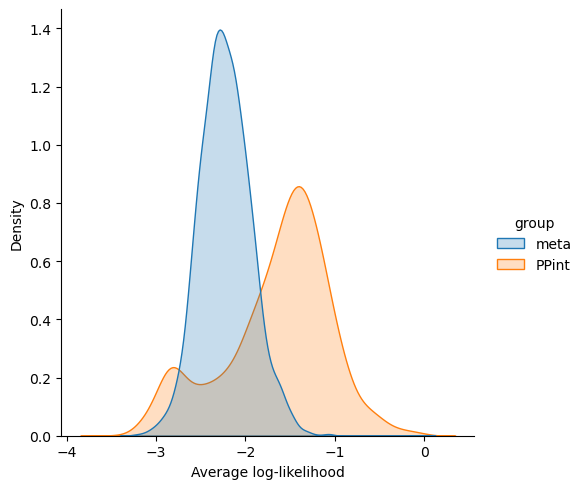

In [28]:
df_a_plot = meta_averageLL_pPLL_df[["binder_avgLL"]].copy()
df_a_plot["group"] = "meta"   # or "targets", or whatever

df_b_plot = PPint_averageLL_pPLL_df[["binder_avgLL"]].copy()
df_b_plot["group"] = "PPint"   # or "binders", etc.

plot_df = pd.concat([df_a_plot, df_b_plot], ignore_index=True)

sns.displot(
    plot_df,
    x="binder_avgLL",
    hue="group",
    kind="kde",
    fill=True,
    common_norm=False,   # don't force areas to sum to 1 together
)
plt.xlabel("Average log-likelihood")
plt.show()

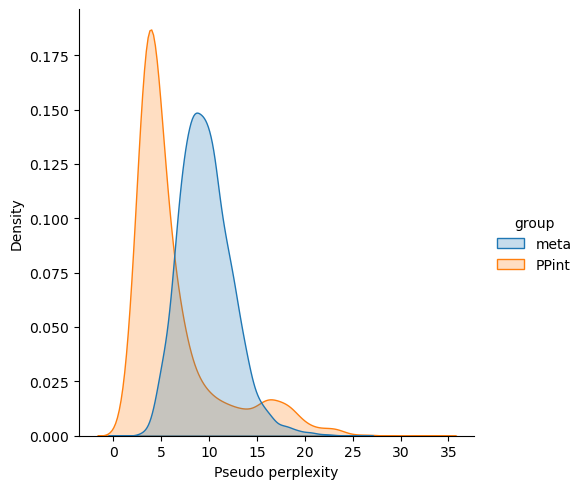

In [26]:
df_a_plot = meta_averageLL_pPLL_df[["pseudo_perplexity"]].copy()
df_a_plot["group"] = "meta"   # or "targets", or whatever

df_b_plot = PPint_averageLL_pPLL_df[["pseudo_perplexity"]].copy()
df_b_plot["group"] = "PPint"   # or "binders", etc.

plot_df = pd.concat([df_a_plot, df_b_plot], ignore_index=True)

sns.displot(
    plot_df,
    x="pseudo_perplexity",
    hue="group",
    kind="kde",
    fill=True,
    common_norm=False,   # don't force areas to sum to 1 together
)
plt.xlabel("Pseudo perplexity")
plt.show()

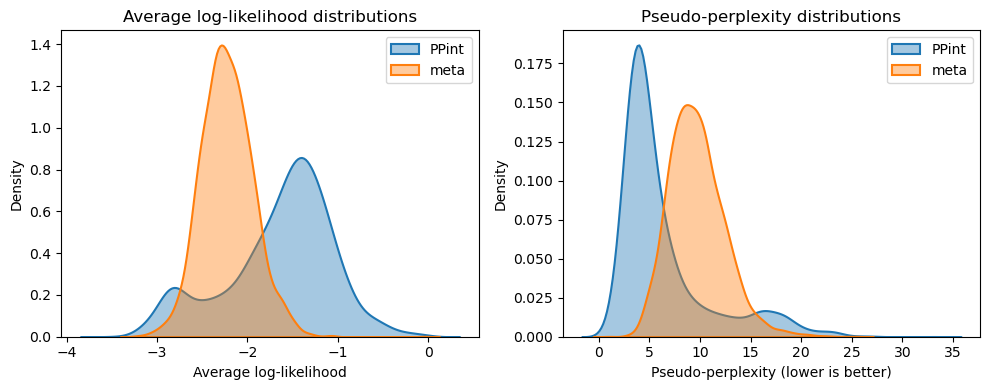

In [31]:
# build the combined dataframe
df_a_plot = meta_averageLL_pPLL_df[["binder_avgLL"]].copy()
df_a_plot["group"] = "meta"
df_b_plot = PPint_averageLL_pPLL_df[["binder_avgLL"]].copy()
df_b_plot["group"] = "PPint"

plot_df = pd.concat([df_a_plot, df_b_plot], ignore_index=True)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for group_name, subdf in plot_df.groupby("group"):
    sns.kdeplot(
        data=subdf,
        x="binder_avgLL",
        fill=True,
        alpha=0.4,
        linewidth=1.5,
        ax=axs[0],
        label=group_name,
        common_norm=False,
    )

axs[0].set_xlabel("Average log-likelihood")
axs[0].set_ylabel("Density")
axs[0].set_title("Average log-likelihood distributions")
axs[0].legend()


df_a_pp = meta_averageLL_pPLL_df[["pseudo_perplexity"]].copy()
df_a_pp["group"] = "meta"

df_b_pp = PPint_averageLL_pPLL_df[["pseudo_perplexity"]].copy()
df_b_pp["group"] = "PPint"

plot_df_pp = pd.concat([df_a_pp, df_b_pp], ignore_index=True)

for group_name, subdf in plot_df_pp.groupby("group"):
    sns.kdeplot(
        data=subdf,
        x="pseudo_perplexity",
        fill=True,
        alpha=0.4,
        linewidth=1.5,
        ax=axs[1],
        label=group_name,
    )

axs[1].set_xlabel("Pseudo-perplexity (lower is better)")
axs[1].set_ylabel("Density")
axs[1].set_title("Pseudo-perplexity distributions")
axs[1].legend()

plt.tight_layout()
plt.show()